# Compare the integral time scales from both the idealised and SUNTANS results

In [1]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map
from tqdm import tqdm

import sfoda.suntans.sunxarray as sxr
import pk2015_utils as utils
import speccy
import nonstat_itides_jax as nsjax
import nonstat_itides as nsit

In [2]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [3]:
def integral_timescale(covfunc, covparams, tmax=500, N=1000):
    t = np.linspace(0, tmax, N) # days

    acf = covfunc(t, t[0], covparams)
    
    return 1./covparams[0]**2 * np.trapz(acf, t)



In [4]:
# Load the suntans results
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)

In [5]:
# paramsfile = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_fD2D1_vc.nc'
# scenario = 'seasonaltides_meso_fD2D1_vc'

paramsfile = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_M2S2_vc.nc'
scenario = 'seasonaltides_meso_M2S2_vc'

units='cm s$^{-1}$'
vmax=5.
varname='vc'

In [6]:
ds_params = xr.open_dataset(paramsfile, engine='h5netcdf')
# ds_params = xr.open_dataset(paramsfile, engine='zarr')

# These need filling in??
ds_params.suntans.xv=ds_params.xv.values
ds_params.suntans.yv=ds_params.yv.values

ds_params

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, params: 9, Nk: 80, time: 8761, Np: 454016)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r      (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, params, Nk, Np
Data variables:
    cells    (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    data     (Nc, params) float64 ...
    dv       (Nc) float64 ...
    dz       (Nk) float64 ...
    nfaces   (Nc) int32 6 6 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6 6 6
    xp       (Np) float64 125.2 114.2 136.3 125.4 ... 117.0 117.0 117.1 117.1
    xv       (Nc) float64 109.0 109.1 109.1 109.2 ... 117.7 117.7 117.7 117.9
    yp       (Np) float64 -14.48 -22.48 -13.24 -14.54 ... -18.27 -18.27 -18.26
    yv       (Nc) float64 -19.4 -19.5 -19.61 -19.71 ... -13.1 -13.12 -13.07
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 None)

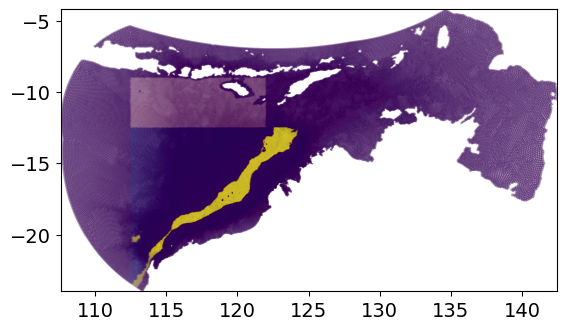

In [7]:
# Compute parameters in different regions

# Lower basin
regionA = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<130.) &\
    (ds_params.suntans.yv<-12.5) & (ds_params.dv>900)

# NWS
regionB = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<130.) &\
    (ds_params.suntans.yv<-12.5) & (ds_params.dv<900) & (ds_params.dv>200)

# Upper basin
# regionC = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<130.) &\
#     (ds_params.suntans.yv>-12.5) & (ds_params.suntans.yv<-8.0) & (ds_params.dv>900)

regionC = (ds_params.suntans.xv>112.5) & (ds_params.suntans.xv<122.) &\
    (ds_params.suntans.yv>-12.5) & (ds_params.suntans.yv<-9.0) & (ds_params.dv>900)

ds_params.suntans.plotcelldata(regionA, alpha=0.1, cmap='RdBu',colorbar=False)
ds_params.suntans.plotcelldata(regionC, alpha=0.1, cmap='gist_ncar',colorbar=False)
ds_params.suntans.plotcelldata(regionB, alpha=0.1, colorbar=False)


In [8]:
# tau_M = ds_params['data'].isel(params=1).values
# gamma_M = ds_params['data'].isel(params=2).values
# tau_D2 = ds_params['data'].isel(params=6).values

# T_M = np.zeros_like(tau_M)
# T_D2 = np.zeros_like(tau_M)

# acf = nsjax.gamma_exp_1d

# for ii in tqdm(range(T_M.shape[0])):
#     T_M[ii] =  integral_timescale(acf, (1, tau_M[ii], gamma_M[ii]), tmax=500, N=1000)
#     T_D2[ii] =  integral_timescale(acf, (1, tau_D2[ii], 1.5), tmax=500, N=1000)

tau_M = ds_params['data'].isel(params=1).values
gamma_M = ds_params['data'].isel(params=2).values
# tau_D2 = ds_params['data'].isel(params=5).values # M2
# gamma_D2 = ds_params['data'].isel(params=7).values
# eta_D2 = ds_params['data'].isel(params=3).values

name = 'S2'
tau_D2 = ds_params['data'].isel(params=6).values #S2
gamma_D2 = ds_params['data'].isel(params=8).values
eta_D2 = ds_params['data'].isel(params=4).values

eta_M = ds_params['data'].isel(params=0).values


T_M = np.zeros_like(tau_M)
T_D2 = np.zeros_like(tau_M)

acf = nsjax.gamma_exp_1d

for ii in tqdm(range(T_M.shape[0])):
    T_M[ii] =  integral_timescale(acf, (1, tau_M[ii], gamma_M[ii]), tmax=500, N=1000)
    T_D2[ii] =  integral_timescale(acf, (1, tau_D2[ii], gamma_D2[ii]), tmax=500, N=1000)

100%|██████████| 225368/225368 [01:47<00:00, 2087.21it/s]


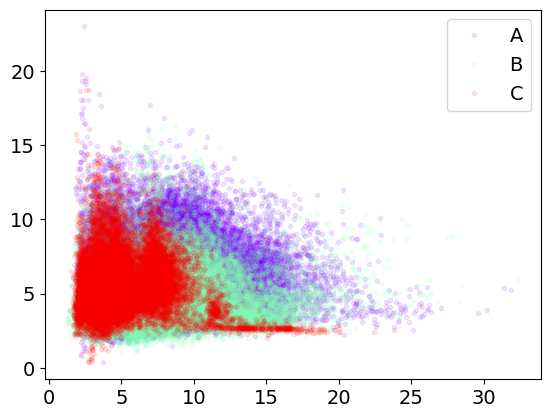

In [9]:
cmap = 'rainbow'
cmap = plt.colormaps.get_cmap(cmap)
colors = [cmap(ii) for ii in np.linspace(0,1,3)]

plt.figure()
plt.plot(T_M[regionA], T_D2[regionA], '.' , alpha=0.1, c=colors[0])
plt.plot(T_M[regionB], T_D2[regionB], '.' , alpha=0.1, c=colors[1])
plt.plot(T_M[regionC], T_D2[regionC], '.' , alpha=0.1, c=colors[2])
plt.legend(('A','B','C'))

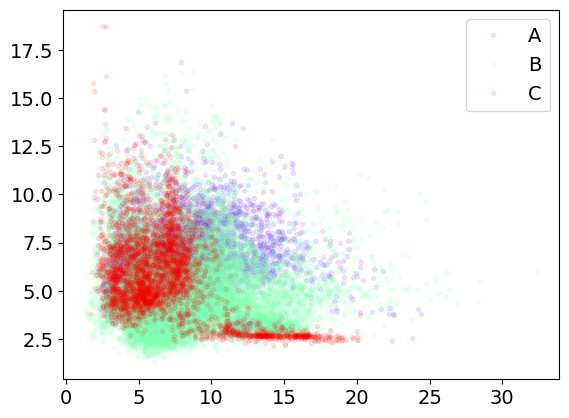

In [10]:


# good = (eta_M>0.05) & (eta_D2>0.025) # M2
good = (eta_M>0.05) & (eta_D2>0.015)

plt.figure()
plt.plot(T_M[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(T_M[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(T_M[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

plt.legend(('A','B','C'))

Text(0.5, 0, '$T_m$')

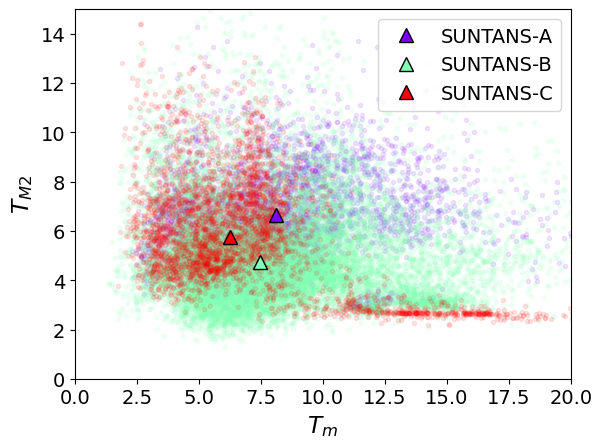

In [11]:
plt.figure()
ax=plt.subplot(111)
plt.plot(T_M[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(T_M[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(T_M[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(T_M[regionA & good]), np.median(T_D2[regionA & good]), '^' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(T_M[regionB & good]), np.median(T_D2[regionB & good]), '^' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(T_M[regionC & good]), np.median(T_D2[regionC & good]), '^' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend([p1,p2,p3],('SUNTANS-A','SUNTANS-B','SUNTANS-C'))
plt.ylim(0,15)
plt.xlim(0,20)
ax.set_ylabel('$T_{M2}$')
ax.set_xlabel('$T_m$')


Text(0.5, 0, '$\\eta_m$')

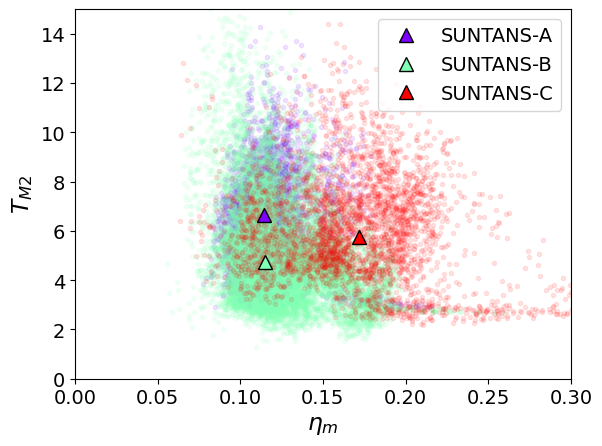

In [12]:
plt.figure()
ax=plt.subplot(111)
plt.plot(eta_M[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(eta_M[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(eta_M[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(eta_M[regionA & good]), np.median(T_D2[regionA & good]), '^' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(eta_M[regionB & good]), np.median(T_D2[regionB & good]), '^' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(eta_M[regionC & good]), np.median(T_D2[regionC & good]), '^' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend([p1,p2,p3],('SUNTANS-A','SUNTANS-B','SUNTANS-C'))
plt.ylim(0,15)
plt.xlim(0,0.3)
ax.set_ylabel('$T_{M2}$')
ax.set_xlabel('$\eta_m$')

Text(0.5, 0, '$\\eta_m$')

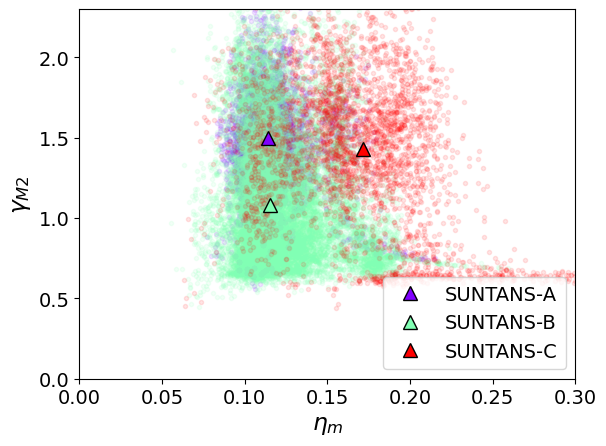

In [13]:
plt.figure()
ax=plt.subplot(111)
plt.plot(eta_M[regionA & good], gamma_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(eta_M[regionB & good], gamma_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(eta_M[regionC & good], gamma_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(eta_M[regionA & good]), np.median(gamma_D2[regionA & good]), '^' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(eta_M[regionB & good]), np.median(gamma_D2[regionB & good]), '^' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(eta_M[regionC & good]), np.median(gamma_D2[regionC & good]), '^' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend([p1,p2,p3],('SUNTANS-A','SUNTANS-B','SUNTANS-C'))
plt.ylim(0,2.3)
plt.xlim(0,0.3)
ax.set_ylabel('$\gamma_{M2}$')
ax.set_xlabel('$\eta_m$')

Text(0.5, 0, '$L_m$')

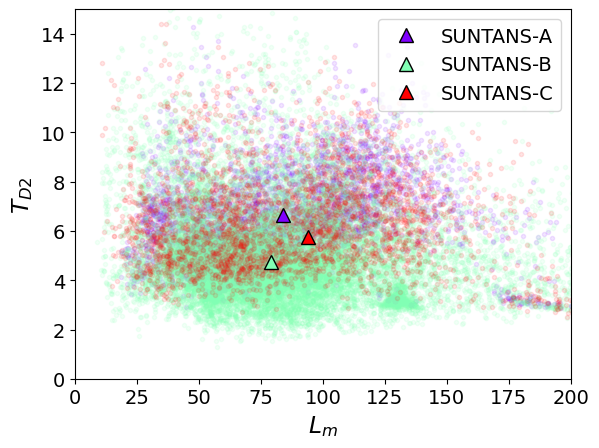

In [14]:
L_M = eta_M * T_M *86400 / 1000 # km


plt.figure()
ax=plt.subplot(111)
plt.plot(L_M[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(L_M[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(L_M[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(L_M[regionA & good]), np.median(T_D2[regionA & good]), '^' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(L_M[regionB & good]), np.median(T_D2[regionB & good]), '^' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(L_M[regionC & good]), np.median(T_D2[regionC & good]), '^' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend([p1,p2,p3],('SUNTANS-A','SUNTANS-B','SUNTANS-C'))
plt.ylim(0,15)
plt.xlim(0,200)
ax.set_ylabel('$T_{D2}$')
ax.set_xlabel('$L_m$')

# Load the idealised model data


In [15]:
limits = {
    'η_m':[0., 0.6],
    'τ_m':[0,20],
    'γ_m':[1,2.],
    'η_D2':[0, 0.2],
    'τ_D2':[0,15],
    'γ_D2':[1,2.],
}
scenarios = ['wp5','wp6','wp75','wp8','wp9']
scenario_names = ['KE1','KE2','KE2.5','KE3','KE4']

9.229236167141835 5.474102731679928
4.229912914866922 4.319362223545922
3.8001230036427005 2.5706575156664186
3.7579499282560507 2.2809086141842956
4.27636225791563 1.536284574155222


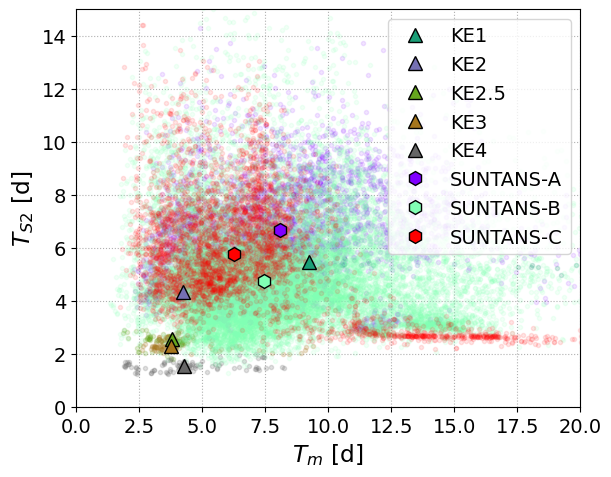

In [16]:
plt.figure(figsize=(6,5))
ax=plt.subplot(111)

acf = nsjax.gamma_exp_1d
covfunc = nsjax.itide_D2_meso_gammaexp
cmap = plt.colormaps.get_cmap('Dark2')
colors2 = [cmap(ii) for ii in np.linspace(0,1,5)]

p=[]
for cc, scenario in zip(colors2, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)
    data=ds['data'].values[-100:,:]
    #data[:,0] = 1.
    #data[:,3] = 1.
    n = data.shape[0]
    T_meso = np.zeros((n,))
    T_it = np.zeros((n,))
    for ii in range(n):
        T_meso[ii] = integral_timescale(acf, data[ii,0:3])
        T_it[ii] = integral_timescale(acf, data[ii,3::])

    idx = ~np.isnan(T_meso)
    p1, = plt.plot(np.median(T_meso[idx]), np.median(T_it[idx]),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    #plt.plot(T_meso*data[:,0]*86400/1000, T_it,'.',c=cc, alpha=0.2)
    plt.plot(T_meso, T_it,'.',c=cc, alpha=0.2)
    p.append(p1)

    print(np.median(T_meso[idx]), np.median(T_it[idx]))
#     #
#plt.legend(p, scenario_names)

# paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel('$T_{S2}$ [d]')
ax.set_xlabel('$T_m$ [d]')
ax.set_ylim(0,7.5)
#ax.set_xlim(0,250)
# ax.set_xlim(0, 15)

plt.grid(True, ls=':')
# plt.tight_layout()

plt.tight_layout()

# plt.figure()
# ax=plt.subplot(111)
plt.plot(T_M[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(T_M[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(T_M[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(T_M[regionA & good]), np.median(T_D2[regionA & good]), 'h' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(T_M[regionB & good]), np.median(T_D2[regionB & good]), 'h' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(T_M[regionC & good]), np.median(T_D2[regionC & good]), 'h' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend(p+[p1,p2,p3],scenario_names+['SUNTANS-A','SUNTANS-B','SUNTANS-C'])
plt.ylim(0,15)
plt.xlim(0,20)
# ax.set_ylabel('$T_{D2}$')
# ax.set_xlabel('$T_m$')
plt.savefig('../FIGURES/combined_T_vs_TS2.png', dpi=150)

0.07879884314360594 5.474102731679928
0.1719232845452524 4.319362223545922
0.19136770902115569 2.5706575156664186
0.19351527863711818 2.2809086141842956
0.17005599100120677 1.536284574155222


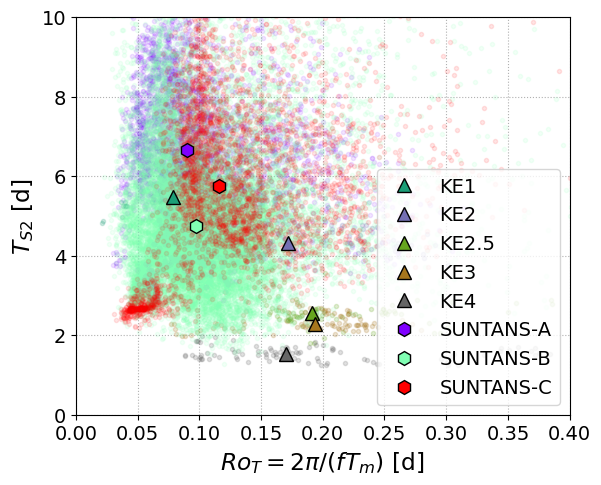

In [42]:
plt.figure(figsize=(6,5))
ax=plt.subplot(111)

acf = nsjax.gamma_exp_1d
covfunc = nsjax.itide_D2_meso_gammaexp
cmap = plt.colormaps.get_cmap('Dark2')
colors2 = [cmap(ii) for ii in np.linspace(0,1,5)]

p=[]
for cc, scenario in zip(colors2, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)
    data=ds['data'].values[-100:,:]
    #data[:,0] = 1.
    #data[:,3] = 1.
    n = data.shape[0]
    T_meso = np.zeros((n,))
    T_it = np.zeros((n,))
    for ii in range(n):
        T_meso[ii] = integral_timescale(acf, data[ii,0:3])
        T_it[ii] = integral_timescale(acf, data[ii,3::])

    idx = ~np.isnan(T_meso)

    Ro_2 = 2*np.pi/(f0*T_meso*86400)
    
    p1, = plt.plot(np.median(Ro_2[idx]), np.median(T_it[idx]),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    #plt.plot(T_meso*data[:,0]*86400/1000, T_it,'.',c=cc, alpha=0.2)
    plt.plot(Ro_2, T_it,'.',c=cc, alpha=0.2)
    p.append(p1)

    print(np.median(Ro_2[idx]), np.median(T_it[idx]))
#     #
#plt.legend(p, scenario_names)

# paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel('$T_{S2}$ [d]')
ax.set_xlabel('$Ro_T=2\pi/(f T_m)$ [d]')
ax.set_ylim(0,7.5)
#ax.set_xlim(0,250)
# ax.set_xlim(0, 15)

plt.grid(True, ls=':')
# plt.tight_layout()

plt.tight_layout()

# Add in the suntans data
Ro_2s = 2*np.pi/(f0*T_M*86400)
# plt.figure()
# ax=plt.subplot(111)
plt.plot(Ro_2s[regionA & good], T_D2[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(Ro_2s[regionB & good], T_D2[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(Ro_2s[regionC & good], T_D2[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(Ro_2s[regionA & good]), np.median(T_D2[regionA & good]), 'h' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(Ro_2s[regionB & good]), np.median(T_D2[regionB & good]), 'h' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(Ro_2s[regionC & good]), np.median(T_D2[regionC & good]), 'h' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend(p+[p1,p2,p3],scenario_names+['SUNTANS-A','SUNTANS-B','SUNTANS-C'])
plt.ylim(0,10)
plt.xlim(0,0.4)
# ax.set_ylabel('$T_{D2}$')
# ax.set_xlabel('$T_m$')
plt.savefig('../FIGURES/combined_TS2_vs_RoT.png', dpi=150)

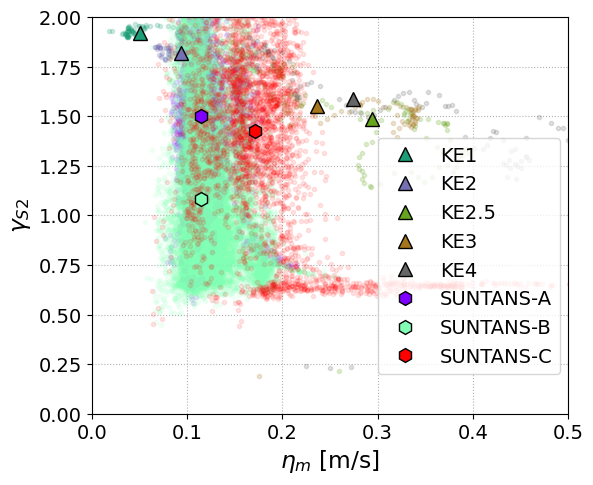

In [46]:
plt.figure(figsize=(6,5))
ax=plt.subplot(111)

acf = nsjax.gamma_exp_1d
covfunc = nsjax.itide_D2_meso_gammaexp
cmap = plt.colormaps.get_cmap('Dark2')
colors2 = [cmap(ii) for ii in np.linspace(0,1,5)]

p=[]
for cc, scenario in zip(colors2, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)
    data=ds['data'].values[-100:,:]
    #data[:,0] = 1.
    #data[:,3] = 1.
    idx = ~np.isnan(data[:,0])
    xdata = data[:,0]
    ydata = data[:,5]
    
    p1, = plt.plot(np.median(xdata[idx]), np.median(ydata[idx]),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    #plt.plot(T_meso*data[:,0]*86400/1000, T_it,'.',c=cc, alpha=0.2)
    plt.plot(xdata, ydata,'.',c=cc, alpha=0.2)
    p.append(p1)

    #print(np.median(Ro_2[idx]), np.median(T_it[idx]))
#     #
#plt.legend(p, scenario_names)

# paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel('$\gamma_{S2}$')
ax.set_xlabel('$\eta_m$ [m/s]')
#ax.set_xlim(0,250)
# ax.set_xlim(0, 15)

plt.grid(True, ls=':')
# plt.tight_layout()

plt.tight_layout()

# Add in the suntans data
xdata, ydata = eta_M, gamma_D2
# plt.figure()
# ax=plt.subplot(111)
plt.plot(xdata[regionA & good], ydata[regionA & good], '.' , alpha=0.1, c=colors[0])
plt.plot(xdata[regionB & good], ydata[regionB & good], '.' , alpha=0.1, c=colors[1])
plt.plot(xdata[regionC & good], ydata[regionC & good], '.' , alpha=0.1, c=colors[2])

p1,=plt.plot(np.median(xdata[regionA & good]), np.median(ydata[regionA & good]), 'h' , c=colors[0],ms=10, zorder=1e6, markeredgecolor='k')
p2,=plt.plot(np.median(xdata[regionB & good]), np.median(ydata[regionB & good]), 'h' , c=colors[1],ms=10, zorder=1e6, markeredgecolor='k')
p3,=plt.plot(np.median(xdata[regionC & good]), np.median(ydata[regionC & good]), 'h' , c=colors[2],ms=10, zorder=1e6, markeredgecolor='k')

plt.legend(p+[p1,p2,p3],scenario_names+['SUNTANS-A','SUNTANS-B','SUNTANS-C'], loc=(0.6, 0.1))
plt.ylim(0,2)
plt.xlim(0,0.5)
# ax.set_ylabel('$T_{D2}$')
# ax.set_xlabel('$T_m$')
plt.savefig('../FIGURES/combined_gammaD2_vs_etam.png', dpi=150)

## Key points

 - The median integral time scale for the mesoscale field was 4 - 9 d for both the realistic and idealised runs
 - Four of the idealised runs were 3 - 4 d (KE 1 was 9 d) and the two offshore realistic regions (A and C) were 4.5 and 5.5 d, respectively.
 - The shelf (region B) was anomalous lower T_D2 but higher T_M. 
 - Conclusion: eddy velocity scale eta_m was a more reliable indicator of the non-phase-locked internal tide timescale than the eddy timescale. The relationship to an eddy length scale was not tested.



# Compare with the vorticity scale

In [17]:
def load_scenario(scenario):
    ncfiles = {'wp5':
             [
             '../DATA/ROMS/wp5/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp5/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010220-00010410.nc'
             ],
               'wp6':
             [
             '../DATA/ROMS/wp6/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp6/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp6/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp6/t2/inst_00010220-00010410.nc',
             ],
               'wp75':
             [
             '../DATA/ROMS/wp75/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp75/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp75/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp75/t2/inst_00010220-00010410.nc',
             ],
                'wp8':
             [
             '../DATA/ROMS/wp8/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp8/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010220-00010410.nc'
             ],
               'wp9':
             [
             '../DATA/ROMS/wp9/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp9/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010220-00010410.nc'
             ],
              }
    
    ds0 = xr.open_mfdataset(ncfiles[scenario][0:2])
    ds1 = xr.open_mfdataset(ncfiles[scenario][2:4])
    
    dt1 = ds0['time_instant'][-1]-ds0['time_instant'][0]
    ds1['time_instant'] = ds1['time_instant']+dt1
    ds1['time_counter'] = ds1['time_counter']+dt1

    if len(ncfiles[scenario])>4:
        ds2 = xr.open_mfdataset(ncfiles[scenario][4:6])
        dt2 = ds1['time_instant'][-1]-ds1['time_instant'][0]
        
        ds2['time_instant'] = ds2['time_instant']+dt1+dt2
        ds2['time_counter'] = ds2['time_counter']+dt1+dt2

        return xr.concat([ds0, ds1, ds2], dim='time_counter')

    else:
        return xr.concat([ds0, ds1], dim='time_counter')
        

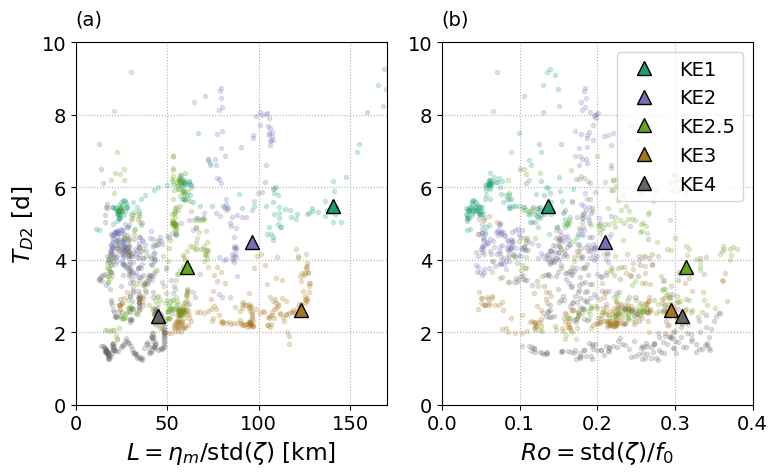

In [30]:
f0 = 1e-4 # Central coriolis frequency 

acf = nsjax.gamma_exp_1d
covfunc = nsjax.itide_D2_meso_gammaexp

plt.figure(figsize=(8,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
ax1.set_ylim(0,10)
ax2.set_ylim(0,10)

ax1.set_xlim(0,170)
ax2.set_xlim(0,0.4)
ax1.grid(True, ls=':')
ax2.grid(True, ls=':')

p=[]
for cc, scenario in zip(colors2, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds_params = xr.open_dataset(output_nc)

    eta_m = ds_params['data'].isel(params=0)
    data=ds_params['data'].values
    #data[:,0] = 1.
    #data[:,3] = 1.
    n = data.shape[0]
    T_meso = np.zeros((n,))
    T_it = np.zeros((n,))
    for ii in range(n):
        T_meso[ii] = integral_timescale(acf, data[ii,0:3])
        T_it[ii] = integral_timescale(acf, data[ii,3::])
        

    # Load the raw data
    ds = load_scenario(scenario)
    # this needs lining up
    yslice = slice(250,500,1) # Jet
    
    #tslice = slice(1000,None)
    tslice = slice(1000, None, 48)
    
    #ds_v = ds['v_y'].isel(y_vy=yslice, x_vy=0, s_rho_slice0=0, time_counter=tslice).load()
    # Vorticity
    ds_v = ds['rot_y'].isel(y_rhoy=yslice, x_rhoy=0, s_rho_slice0=0, time_counter=tslice).load()
    
    vort = ds_v.std(axis=0)
    L = (eta_m / vort)[:,0]/1000
    Ro = vort/f0

    #L_m = eta_m * T_meso *86400 / 1000 # km

    # Plot
    #p1, = ax1.plot(np.nanmedian(L), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    p1, = ax1.plot(np.nanpercentile(L, 90), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    #p1, = ax1.plot(np.nanpercentile(L_m, 50), np.nanmedian(T_it),'s',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )

    ax1.plot(L, T_it,'.',c=cc, alpha=0.2)

    #p1, = ax2.plot(np.nanmedian(Ro), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    p1, = ax2.plot(np.nanpercentile(Ro, 90), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )

    #plt.plot(T_meso*data[:,0]*86400/1000, T_it,'.',c=cc, alpha=0.2)
    ax2.plot(Ro, T_it,'.',c=cc, alpha=0.2)

    p.append(p1)

plt.legend(p,scenario_names)

ax1.text(0.0,1.05, '(a)', transform=ax1.transAxes)
ax2.text(0.0,1.05, '(b)', transform=ax2.transAxes)
ax1.set_ylabel('$T_{D2}$ [d]')
ax1.set_xlabel('$L=\eta_m$/std($\zeta$) [km]')
ax2.set_xlabel('$Ro=$std($\zeta$)/$f_0$')
plt.tight_layout()
plt.savefig('../FIGURES/TD2_vs_L_Ro.png', dpi=150)

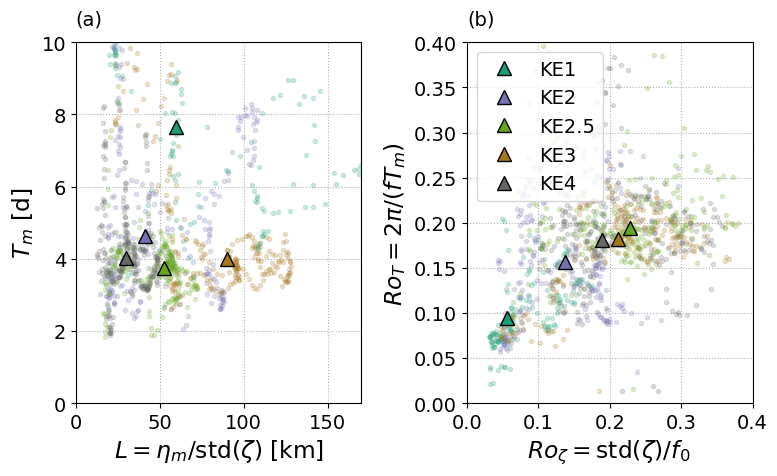

In [37]:
plt.figure(figsize=(8,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
ax1.set_ylim(0,10)
ax2.set_ylim(0,0.4)

ax1.set_xlim(0,170)
ax2.set_xlim(0,0.4)
ax1.grid(True, ls=':')
ax2.grid(True, ls=':')


p=[]
for cc, scenario in zip(colors2, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds_params = xr.open_dataset(output_nc)

    eta_m = ds_params['data'].isel(params=0)
    data=ds_params['data'].values
    #data[:,0] = 1.
    #data[:,3] = 1.
    n = data.shape[0]
    T_meso = np.zeros((n,))
    T_it = np.zeros((n,))
    for ii in range(n):
        T_meso[ii] = integral_timescale(acf, data[ii,0:3])
        T_it[ii] = integral_timescale(acf, data[ii,3::])
        

    # Load the raw data
    ds = load_scenario(scenario)
    # this needs lining up
    yslice = slice(250,500,1) # Jet
    
    #tslice = slice(1000,None)
    tslice = slice(1000, None, 48)
    
    #ds_v = ds['v_y'].isel(y_vy=yslice, x_vy=0, s_rho_slice0=0, time_counter=tslice).load()
    # Vorticity
    ds_v = ds['rot_y'].isel(y_rhoy=yslice, x_rhoy=0, s_rho_slice0=0, time_counter=tslice).load()
    
    vort = ds_v.std(axis=0)
    L = (eta_m / vort)[:,0]/1000
    Ro = vort/f0

    #L_m = eta_m * T_meso *86400 / 1000 # km
    Ro_2 = 2*np.pi/(f0*T_meso*86400)

    # Plot
    #p1, = ax1.plot(np.nanmedian(L), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    p1, = ax1.plot(np.nanpercentile(L, 50), np.nanmedian(T_meso),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    #p1, = ax1.plot(np.nanpercentile(L_m, 50), np.nanmedian(T_it),'s',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )

    ax1.plot(L, T_meso,'.',c=cc, alpha=0.2)

    #p1, = ax2.plot(np.nanmedian(Ro), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    p1, = ax2.plot(np.nanpercentile(Ro,50), np.nanpercentile(Ro_2,50),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )

    #plt.plot(T_meso*data[:,0]*86400/1000, T_it,'.',c=cc, alpha=0.2)
    ax2.plot(Ro, Ro_2,'.',c=cc, alpha=0.2)

    p.append(p1)

plt.legend(p,scenario_names)

ax1.text(0.0,1.05, '(a)', transform=ax1.transAxes)
ax2.text(0.0,1.05, '(b)', transform=ax2.transAxes)
ax1.set_ylabel('$T_{m}$ [d]')
ax1.set_xlabel('$L=\eta_m$/std($\zeta$) [km]')
ax2.set_xlabel('$Ro_{\zeta}=$std($\zeta$)/$f_0$ ')
ax2.set_ylabel('$Ro_T=2\pi/(f T_m)$')

plt.tight_layout()

plt.savefig('../FIGURES/Tm_vs_L_Ro_vs_Ro2.png', dpi=150)

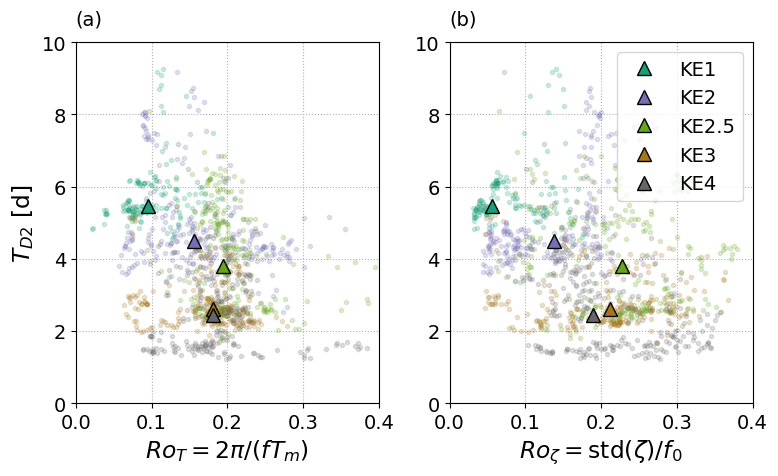

In [39]:
f0 = 1e-4 # Central coriolis frequency 

acf = nsjax.gamma_exp_1d
covfunc = nsjax.itide_D2_meso_gammaexp

plt.figure(figsize=(8,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
ax1.set_ylim(0,10)
ax2.set_ylim(0,10)

ax1.set_xlim(0,0.4)
ax2.set_xlim(0,0.4)
ax1.grid(True, ls=':')
ax2.grid(True, ls=':')

p=[]
for cc, scenario in zip(colors2, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds_params = xr.open_dataset(output_nc)

    eta_m = ds_params['data'].isel(params=0)
    data=ds_params['data'].values
    #data[:,0] = 1.
    #data[:,3] = 1.
    n = data.shape[0]
    T_meso = np.zeros((n,))
    T_it = np.zeros((n,))
    for ii in range(n):
        T_meso[ii] = integral_timescale(acf, data[ii,0:3])
        T_it[ii] = integral_timescale(acf, data[ii,3::])
        

    # Load the raw data
    ds = load_scenario(scenario)
    # this needs lining up
    yslice = slice(250,500,1) # Jet
    
    #tslice = slice(1000,None)
    tslice = slice(1000, None, 48)
    
    #ds_v = ds['v_y'].isel(y_vy=yslice, x_vy=0, s_rho_slice0=0, time_counter=tslice).load()
    # Vorticity
    ds_v = ds['rot_y'].isel(y_rhoy=yslice, x_rhoy=0, s_rho_slice0=0, time_counter=tslice).load()
    
    vort = ds_v.std(axis=0)
    L = (eta_m / vort)[:,0]/1000
    Ro = vort/f0

    Ro_2 = 2*np.pi/(f0*T_meso*86400)

    #L_m = eta_m * T_meso *86400 / 1000 # km

    # Plot
    #p1, = ax1.plot(np.nanmedian(L), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    p1, = ax1.plot(np.nanpercentile(Ro_2, 50), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    #p1, = ax1.plot(np.nanpercentile(L_m, 50), np.nanmedian(T_it),'s',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )

    ax1.plot(Ro_2, T_it,'.',c=cc, alpha=0.2)

    #p1, = ax2.plot(np.nanmedian(Ro), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    p1, = ax2.plot(np.nanpercentile(Ro, 50), np.nanmedian(T_it),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )

    #plt.plot(T_meso*data[:,0]*86400/1000, T_it,'.',c=cc, alpha=0.2)
    ax2.plot(Ro, T_it,'.',c=cc, alpha=0.2)

    p.append(p1)

plt.legend(p,scenario_names)

ax1.text(0.0,1.05, '(a)', transform=ax1.transAxes)
ax2.text(0.0,1.05, '(b)', transform=ax2.transAxes)
ax1.set_ylabel('$T_{D2}$ [d]')
ax1.set_xlabel('$Ro_T=2\pi/(f T_m)$')
ax2.set_xlabel('$Ro_{\zeta}=$std($\zeta$)/$f_0$')
plt.tight_layout()
plt.savefig('../FIGURES/TD2_vs_Ro_T_Ro.png', dpi=150)